In [1]:
# import helpful libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Question: 
#### What are the main factors that affect the number of confirmed cases and deaths caused by the coronavirus?

In [2]:
time_series_covid19_deaths_US = pd.read_csv("time_series_covid19_deaths_US.csv")
time_series_covid19_confirmed_US = pd.read_csv("time_series_covid19_confirmed_US.csv")
abridged_counties = pd.read_csv("abridged_counties.csv")

### 1. Clean our data ###
- Appropriately handle NaN data
- Match FIPS codes between datasets since that's a unique and deterministic value that we can use to join our datasets
- Only keep rows for counties that are included by all datasets (determined by matching FIPS codes)

In [3]:
# Clean abridged counties data

# select the columns we're interested in
useful_columns = ['countyFIPS', 'STATEFP', 'CountyName', 'StateName', 'State',
       'POP_LATITUDE', 'POP_LONGITUDE', '#EligibleforMedicare2018', 'MedicareEnrollment,AgedTot2017', 'DiabetesPercentage', 'HeartDiseaseMortality', 'StrokeMortality', 'Smokers_Percentage', 'RespMortalityRate2014', '#Hospitals', '#ICU_beds', 'dem_to_rep_ratio', 'PopulationDensityperSqMile2010', 'stay at home', '>50 gatherings','>500 gatherings', 'public schools', 'restaurant dine-in', 'entertainment/gym']
counties = abridged_counties[useful_columns].copy()
counties = counties.rename(columns={'countyFIPS':'FIPS', 'POP_LATITUDE':'Lat', 'POP_LONGITUDE':'Lon', 'PopulationDensityperSqMile2010':'Pop_Density'})

# drop invalid entries (rows contain many NaN values that we cannot reasonably fill in)
counties = counties.set_index('FIPS') # index by FIPS code
counties = counties[~(counties.isnull().sum(axis=1) > 5)]

In [4]:
# Define helper functions for cleaning time series data

def make_five_digit_FIPS(data):
    """
    Left-pad FIPS codes that are less than 5 digits with zeros.
    Used to match format of FIPS codes between datasets.
    """
    data['FIPS'] = data['FIPS'].str.zfill(5)
    return data

In [5]:
# Clean Covid-19 confirmed cases time series data

# drop unnecessary columns
ts_confirmed = time_series_covid19_confirmed_US.copy().drop(columns=['UID', 'iso2', 'iso3', 'code3']).rename(columns={'Long_': 'Lon'})

# match FIPS codes to the format used in abridged counties data
ts_confirmed['FIPS'] = ts_confirmed['FIPS'].fillna(0).astype(int).astype(str)
ts_confirmed = make_five_digit_FIPS(ts_confirmed)
ts_confirmed = ts_confirmed[ts_confirmed['FIPS'].isin(counties.index)]
ts_confirmed = ts_confirmed.set_index('FIPS') # index by FIPS code

In [6]:
# Clean Covid-19 deaths time series data

# drop unnecessary columns
ts_deaths = time_series_covid19_deaths_US.copy().drop(columns=['UID', 'iso2', 'iso3', 'code3']).rename(columns={'Long_': 'Lon'})

# match FIPS codes to the format used in abridged counties data
ts_deaths['FIPS'] = ts_deaths['FIPS'].fillna(0).astype(int).astype(str)
ts_deaths = make_five_digit_FIPS(ts_deaths)
ts_deaths = ts_deaths[ts_deaths['FIPS'].isin(counties.index)]
ts_deaths = ts_deaths.set_index('FIPS') # index by FIPS code

In [7]:
# Delete row in abridged counties that doesn't have data in time series

counties = counties.drop(counties[~counties.index.isin(ts_deaths.index)].index)

### 2. Data Tranformation ###
 - Scale data to percentages
 - Consistently record data as proportions to the population (i.e. normalize the data)

In [8]:
# sort all data in the same order

counties_norm = counties.sort_index()
ts_confirmed_norm = ts_confirmed.sort_index()
ts_deaths_norm = ts_deaths.sort_index()

In [9]:
# transform abridged counties data

population = ts_deaths_norm['Population']
scale_by_person = ['#EligibleforMedicare2018', 'MedicareEnrollment,AgedTot2017', '#Hospitals', '#ICU_beds']
counties_norm[scale_by_person] = counties_norm[scale_by_person].divide(population, axis=0).mul(100, axis=0)
scale_to_percentage = ['HeartDiseaseMortality', 'StrokeMortality', 'RespMortalityRate2014']
counties_norm[scale_to_percentage] = counties_norm[scale_to_percentage].divide(100, axis=0)

In [10]:
# transform time series data

scaled_dates = ts_confirmed_norm.iloc[:, 6:].columns
ts_confirmed_norm[scaled_dates] = ts_confirmed_norm[scaled_dates].divide(population, axis=0).mul(100)
ts_deaths_norm[scaled_dates] = ts_deaths_norm[scaled_dates].divide(population, axis=0).mul(100)

### 3. Data Visualizations

- Plot various aspects of our data to observe trends
- Analyze the trends and relationships to drive our models later on

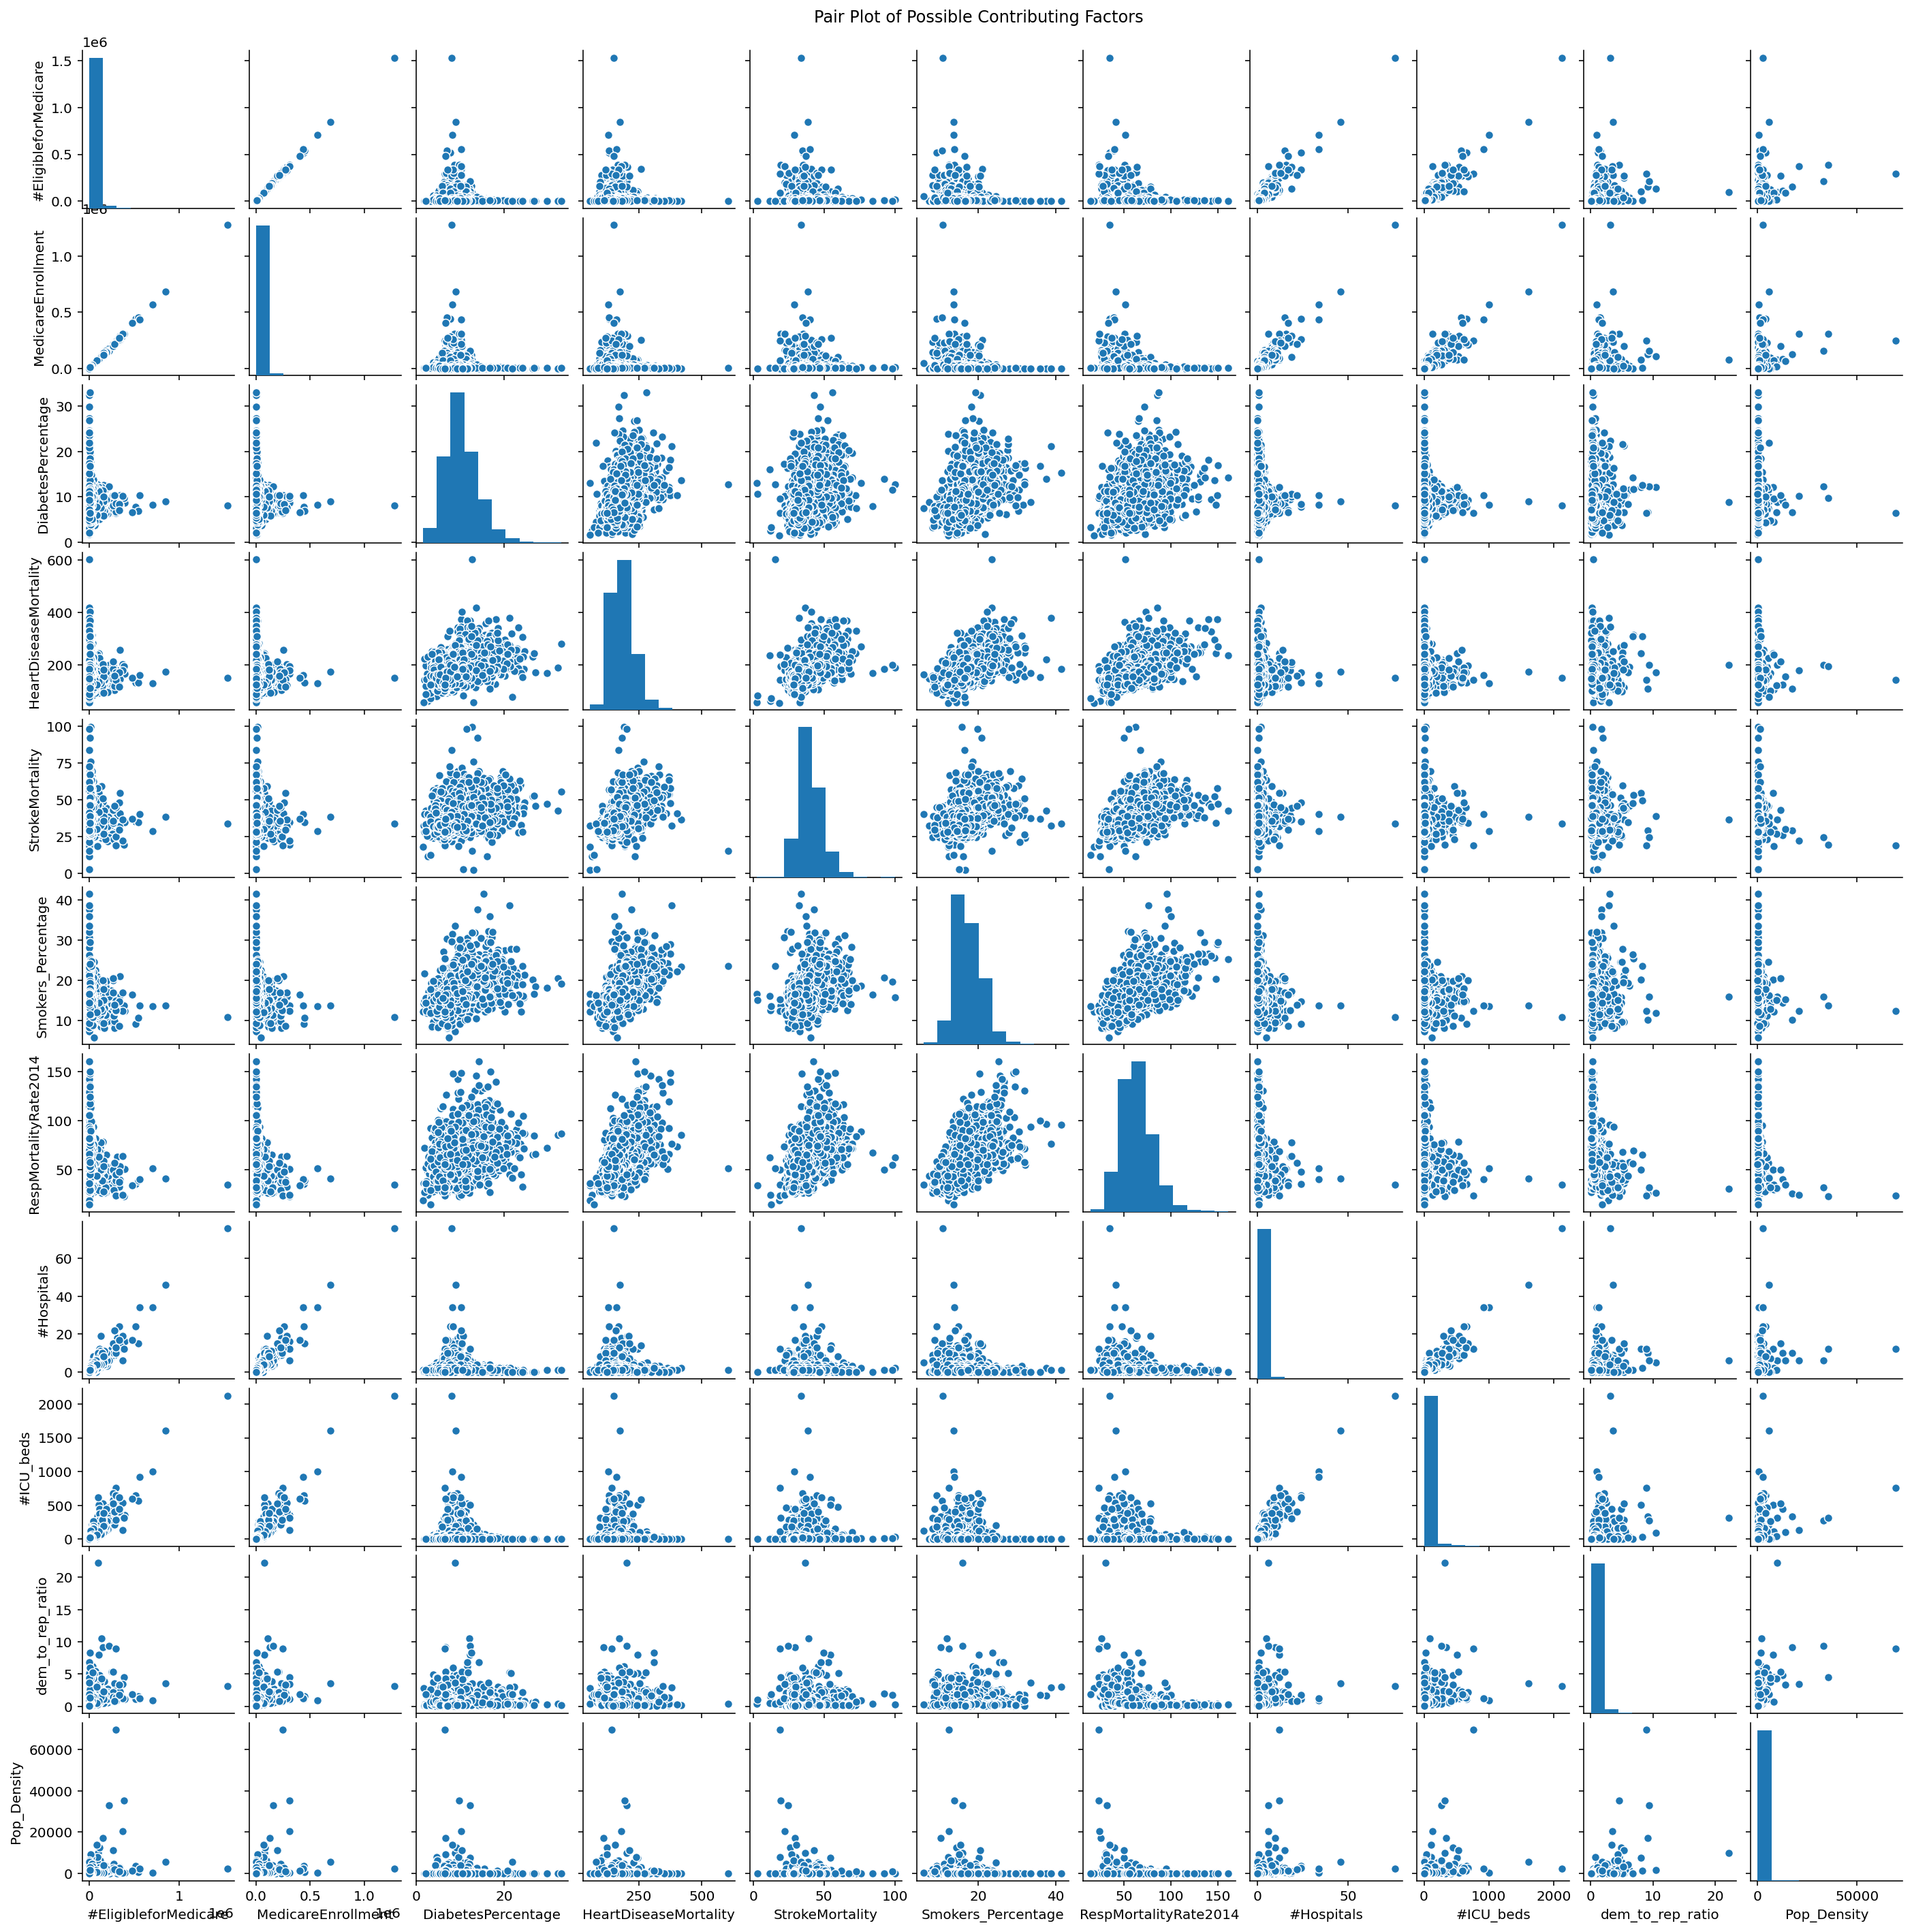

In [11]:
pairplot_df = counties.iloc[:,6:17].rename(columns={'#EligibleforMedicare2018': '#EligibleforMedicare', 'MedicareEnrollment,AgedTot2017':'MedicareEnrollment'})
fig = sns.pairplot(pairplot_df[['#EligibleforMedicare', 'MedicareEnrollment', 'DiabetesPercentage', 'HeartDiseaseMortality', 'StrokeMortality', 'Smokers_Percentage', 'RespMortalityRate2014', '#Hospitals', '#ICU_beds', 'dem_to_rep_ratio', 'Pop_Density']])
fig.fig.suptitle('Pair Plot of Possible Contributing Factors', y=1.02)
fig.fig.set_size_inches((19,19));

Here we examine the relationship between all possible contributing health factors of the spread of the virus. While most of them are uncorrelated, we see a positive linear relationship between factors related to healthcare resources such as number of people eligible and enrolling in Medicare. As we progress with our analysis, we will be careful to not include all of these redundant variables if we're predicting some kind of relationship.

In [12]:
# determine most updated counts of confirmed cases and deaths by extracting value at most recent date

ts_confirmed_total = ts_confirmed_norm.iloc[:,-1]
ts_deaths_total = ts_deaths_norm.iloc[:,-1]

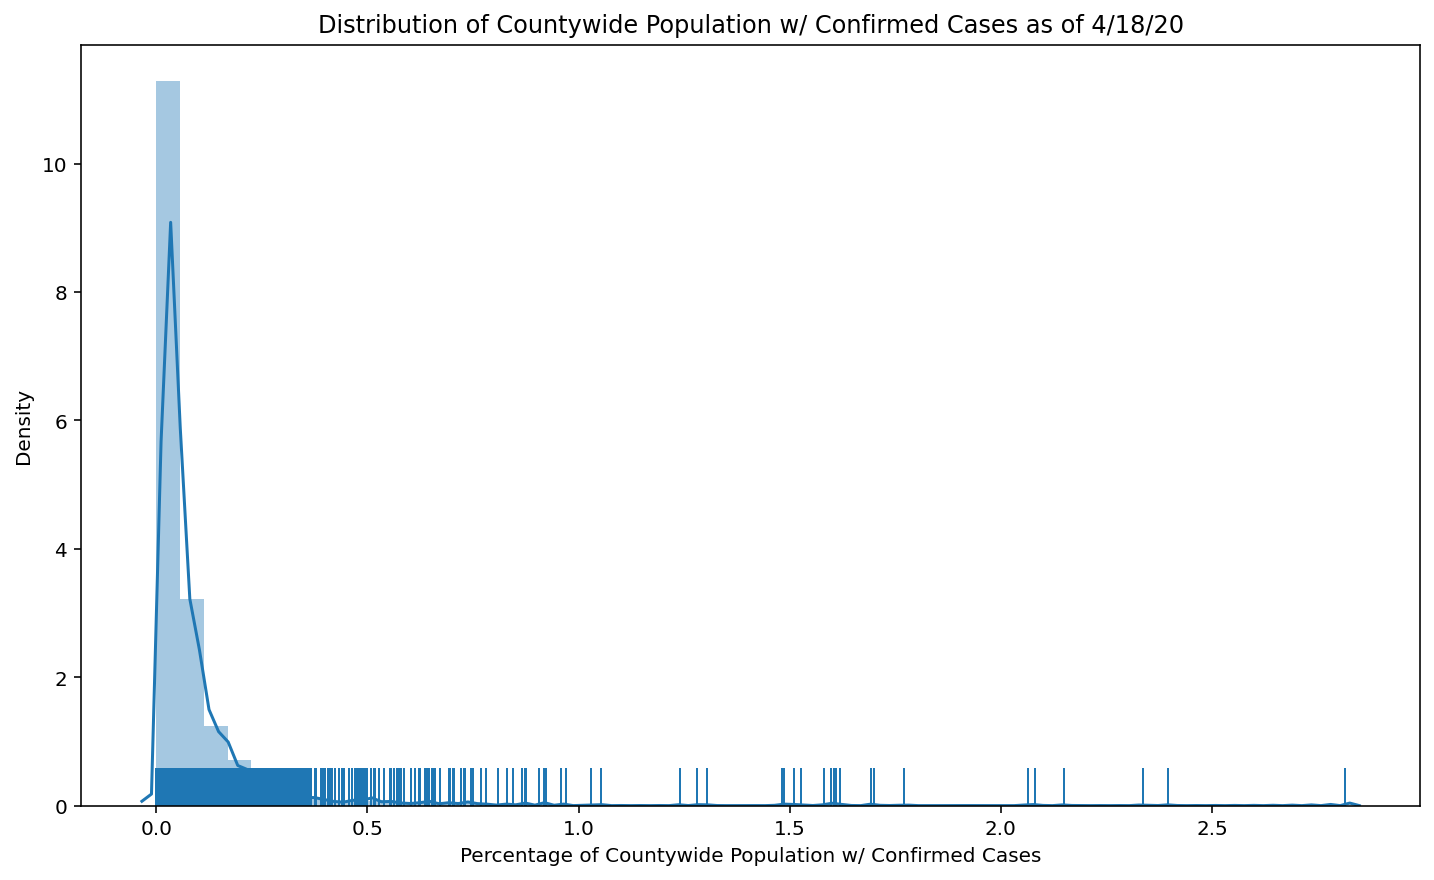

In [13]:
fig = sns.distplot(ts_confirmed_total, rug=True);
fig.set_title('Distribution of Countywide Population w/ Confirmed Cases as of 4/18/20')
fig.set_ylabel('Density')
fig.set_xlabel('Percentage of Countywide Population w/ Confirmed Cases');

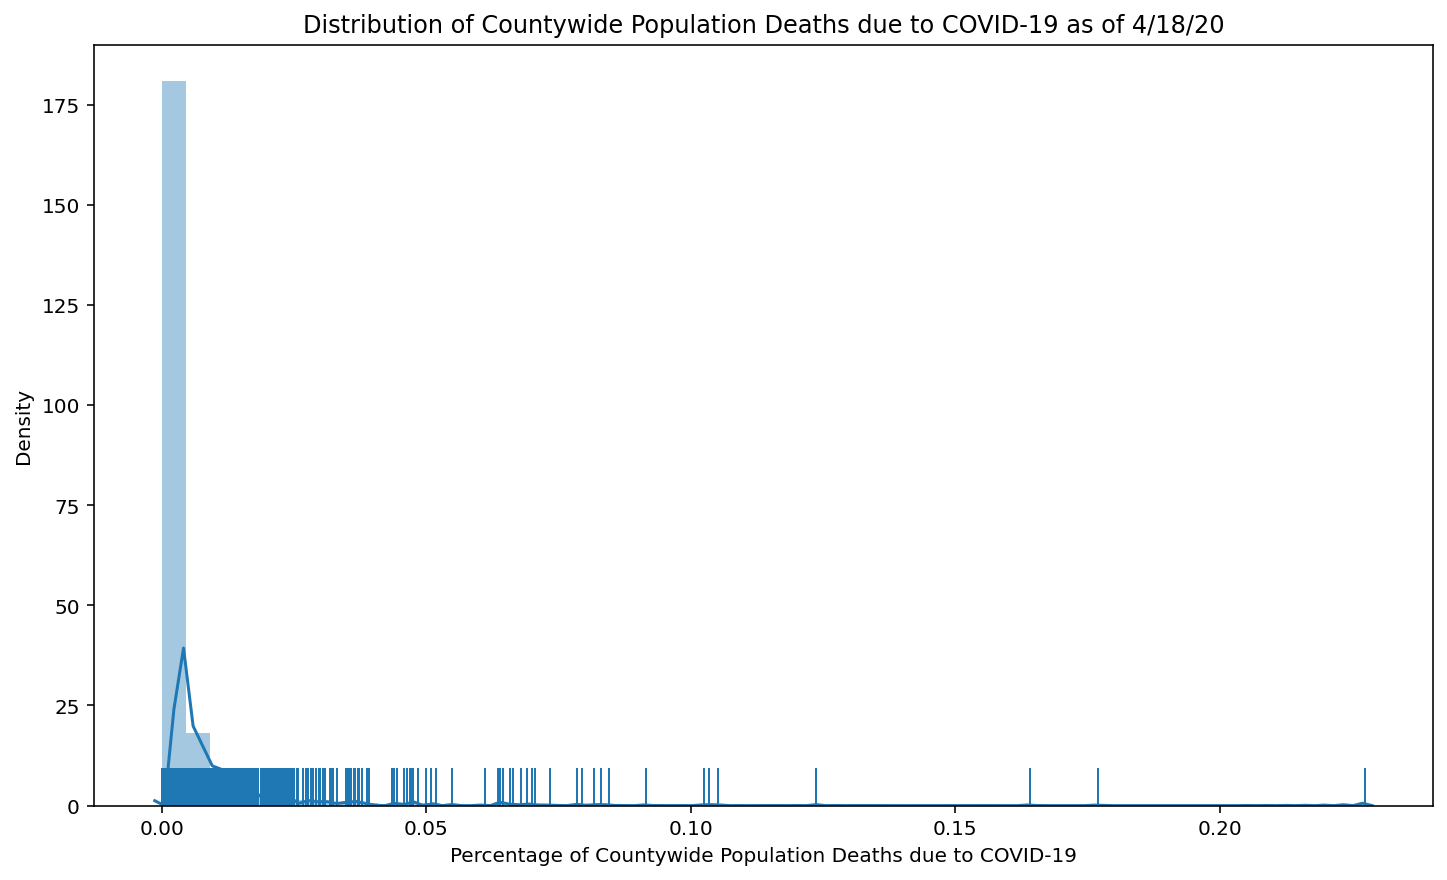

In [14]:
fig = sns.distplot(ts_deaths_total, rug=True);
fig.set_title('Distribution of Countywide Population Deaths due to COVID-19 as of 4/18/20')
fig.set_ylabel('Density')
fig.set_xlabel('Percentage of Countywide Population Deaths due to COVID-19');

Above, we plotted distribution plots of total confirmed cases and total deaths for each county. In both of these plots, we see that most counties have relatively low numbers of cases with a few outliers that have higher values for both confirmed cases and deaths due to COVID-19. For both confimed cases and deaths, we found that the county with the highest proportion of cases and deaths to population is New York.

In [15]:
both_totals = pd.DataFrame([ts_confirmed_total.values, ts_deaths_total.values], index=['Total_Confirmed', 'Total_Deaths'], columns=counties_norm.index).T
total_and_counties = both_totals.join(counties_norm[['#EligibleforMedicare2018', 'MedicareEnrollment,AgedTot2017', 'DiabetesPercentage', 'HeartDiseaseMortality', 'StrokeMortality', 'Smokers_Percentage', 'RespMortalityRate2014', '#Hospitals', '#ICU_beds', 'dem_to_rep_ratio', 'Pop_Density', 'stay at home', '>50 gatherings','>500 gatherings', 'public schools', 'restaurant dine-in', 'entertainment/gym']])
corr_df = total_and_counties.corr()

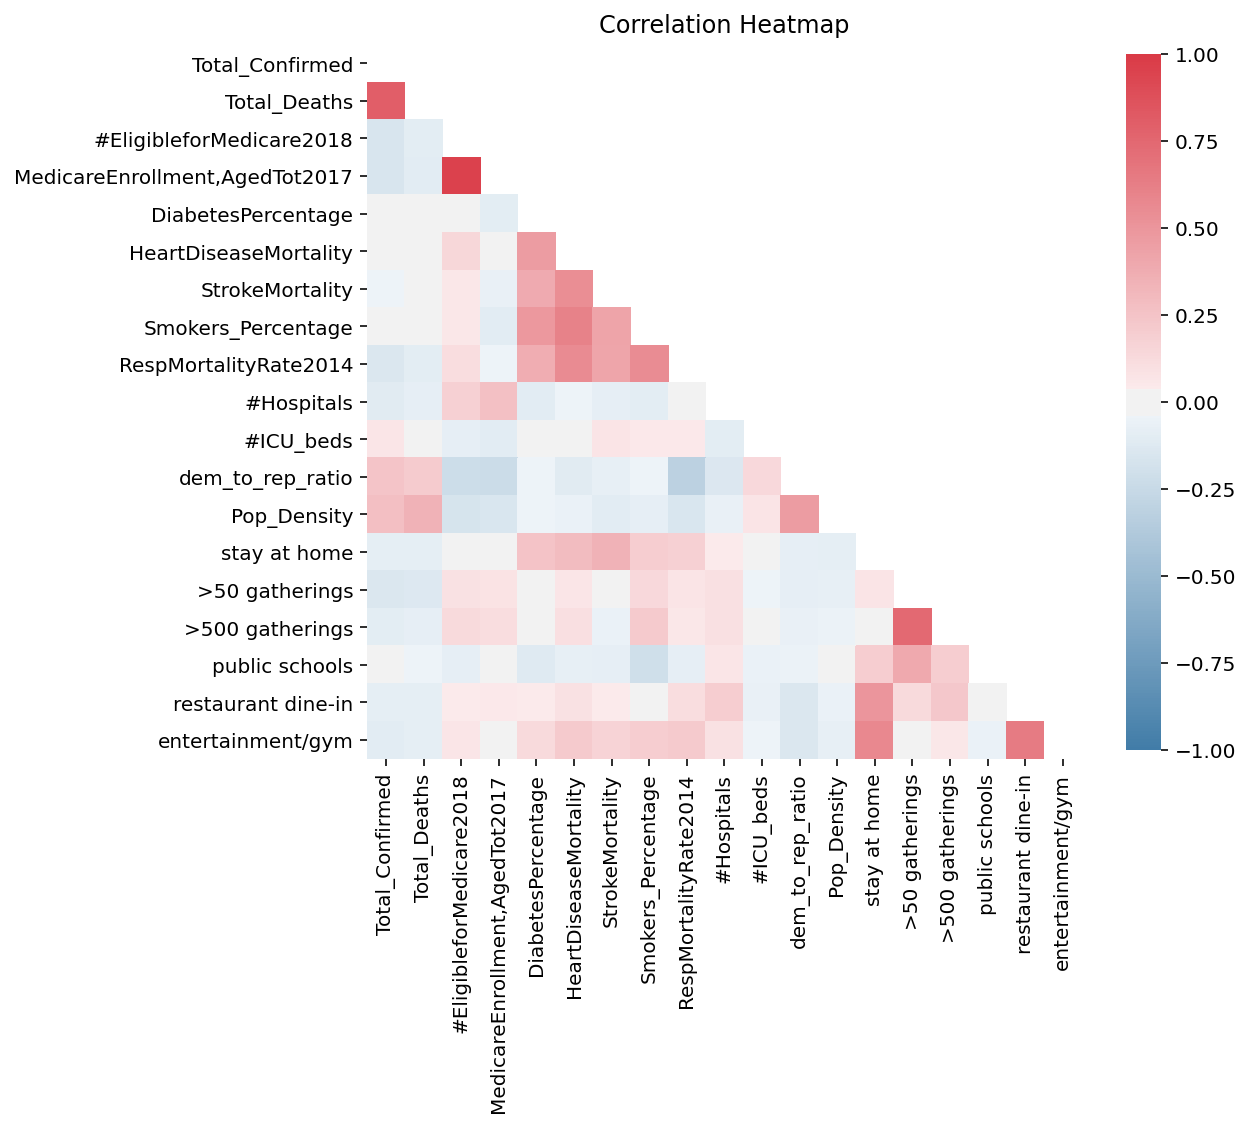

In [16]:
plt.subplots(figsize=(8,8))
plt.title('Correlation Heatmap')
mask = np.triu(np.ones_like(corr_df))
cmap = sns.diverging_palette(240,10,n=100,as_cmap=True)
corr_matrix = sns.heatmap(corr_df, vmin=-1, vmax=1, center=0, cmap=cmap, mask=mask, square=True, cbar_kws={'shrink': 0.8})
fig = corr_matrix.get_figure()

From this correlation matrix, we observe correlation between total number of confirmed cases and factors we hypothesized to be influential to the spread of the virus. We're a bit surprised by the low magnitude of these correlations (most are <0.5). For example, we thought number of ICU beds or hospitals would be more related to the total number of deaths. However, this does not completely eliminate the possibility of stronger relationships between total confirmed cases/deaths and the different factors. Pearson correlation only measures linear relationships, so there may exist some non-linear relationships currently unobservable by this correlation. Nontheless, it's interesting to note the correlations observed here- some interesting ones include positive association between democratic to republican ratio & total number of confirmed cases and negative association between start dates of stay-at-home policies (larger values = more recent) & total number of confirmed cases.

### 4. Inference and Prediction ###
- Predict rates of virus spread and deaths based off of demographic factors
- Select a good model for our data
- Select factors that create the best model and are not redundant
- Tune the model
- Analyze the largest contributing factors

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [18]:
def rmse_score(model, x, y):
    return np.sqrt(np.mean((y - model.predict(x))**2))

def fit_model(x, y):
    """
    Helper function to create and train linear models
    """
    model = LinearRegression()
    model.fit(x, y)
    return model

We will predict the most recent number of confirmed cases and deaths based on demographic factors. We will begin with a simple linear model trained over all factors then improve our model later on. 

In [19]:
# Split dataframes into train and test data (we will train on some counties and use others to test our model)

# extract demographic factors from abridged counties data and normalize data
features = counties_norm.iloc[:,6:]
features = (features.fillna(features.mean()) - np.mean(features)) / np.std(features)

# confirmed cases labeled with "c"
x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(features, ts_confirmed_total, test_size=0.1,
 random_state=2020)

# deaths labeled with "d"
x_train_d, x_test_d, y_train_d, y_test_d = train_test_split(features, ts_deaths_total, test_size=0.1, random_state=2020)

First, we'll create a toy model that always predicts the mean value to get a better understanding of our model error and how well our model is performing.

In [20]:
class ToyModelMean():
    """
    Toy model that will always predict the mean over all y values for every input.
    """
    def __init__(self):
        self.predicted = None

    def fit(self, x, y):
        self.predicted = [np.mean(y)]

    def predict(self, x):
        return self.predicted * len(x)

In [21]:
toy_model_c = ToyModelMean()
toy_model_d = ToyModelMean()

toy_model_c.fit(x_train_c, y_train_c)
toy_model_d.fit(x_train_d, y_train_d)

c_toy_rmse = rmse_score(toy_model_c, x_train_c, y_train_c)
d_toy_rmse = rmse_score(toy_model_d, x_train_d, y_train_d)

print('Toy Model')
print('Training Error (confirmed cases):', c_toy_rmse)
print('Training Error (deaths)', d_toy_rmse)

Toy Model
Training Error (confirmed cases): 0.1810173894922768
Training Error (deaths) 0.010866593166307791


Next, we will create a linear model that uses all demographic factors to predict the number of confirmed cases and deaths in each county.

In [22]:
model_c = fit_model(x_train_c, y_train_c)
model_d = fit_model(x_train_d, y_train_d)

In [23]:
c_train_rmse = rmse_score(model_c, x_train_c, y_train_c)
d_train_rmse = rmse_score(model_d, x_train_d, y_train_d)

c_val_rmse = np.mean(cross_val_score(model_c, x_train_c, y_train_c, scoring=rmse_score, cv=5))
d_val_rmse = np.mean(cross_val_score(model_d, x_train_d, y_train_d, scoring=rmse_score, cv=5))

print('Linear Model w/ all Features')
print(' ')
print('Training Error (confirmed cases):', c_train_rmse)
print('Training Error (deaths)', d_train_rmse)
print(' ')
print('Validation Error (confirmed cases):', c_val_rmse)
print('Validation Error (deaths)', d_val_rmse)

Linear Model w/ all Features
 
Training Error (confirmed cases): 0.16655741526764956
Training Error (deaths) 0.009947658599212452
 
Validation Error (confirmed cases): 0.1701065772838144
Validation Error (deaths) 0.01065139018253237


The training and validation errors were only slightly improved when using the linear model rather than the toy model to predict number of confirmed cases. The linear model is more significantly better when predicting deaths. This wasn't surprisingly to use since we expected it to be difficult to predict these numbers based purely off of demographic factors. It makes sense that the factors are better predictors of deaths than confirmed cases since factors such as number of hospitals and number of ICU beds are more directly related to deaths due to the virus rather than the spread of the virus.

#### Feature Selection: PCA Analysis

Some of the features seem to be correlated with one another based on the correlation heatmap earlier. The dimension of our features can be reduced, so we will now use PCA to select these features.

In [24]:
u, s, vt = np.linalg.svd(features, full_matrices=False)

63.13 percent of variance explained by the first 5 principal components


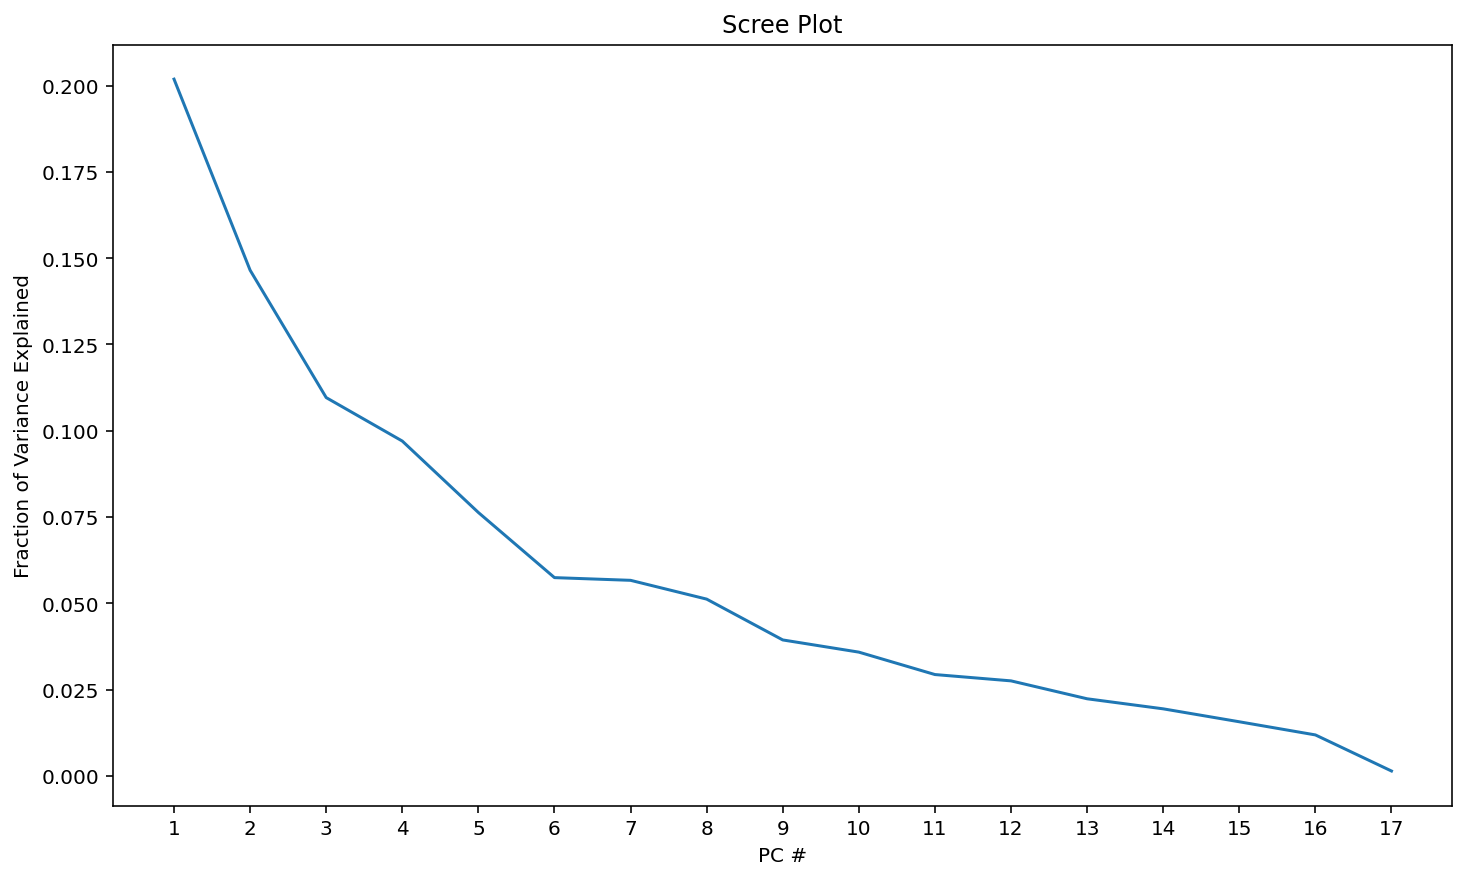

In [25]:
principal_components = s**2 / sum(s**2)
plt.plot(np.arange(1,len(s)+1), principal_components)
plt.xticks(np.arange(1,len(s)+1))
plt.title('Scree Plot')
plt.xlabel('PC #')
plt.ylabel('Fraction of Variance Explained');
print(np.round(np.sum(principal_components[:5])*100, 2), 'percent of variance explained by the first 5 principal components')

In [26]:
# rank 5 approximation
features_approx = pd.DataFrame(u[:, :5] * s[:5] @ vt[:5, :], index=features.index)
x_train_approx_c = features_approx.loc[x_train_c.index]
x_train_approx_d = features_approx.loc[x_train_d.index]
x_test_approx_c = features_approx.loc[x_test_c.index]
x_test_approx_d = features_approx.loc[x_test_d.index]

Now, train our model using just the approximated features

In [27]:
model_approx_c = fit_model(x_train_approx_c, y_train_c)
model_approx_d = fit_model(x_train_approx_d, y_train_d)

In [28]:
c_train_approx_rmse = rmse_score(model_approx_c, x_train_approx_c, y_train_c)
d_train_approx_rmse = rmse_score(model_approx_d, x_train_approx_d, y_train_d)

c_val_approx_rmse = np.mean(cross_val_score(model_approx_c, x_train_approx_c, y_train_c, scoring=rmse_score, cv=5))
d_val_approx_rmse = np.mean(cross_val_score(model_approx_d, x_train_approx_d, y_train_d, scoring=rmse_score, cv=5))

print('Linear Model (Rank 5 Approximation)')
print(' ')
print('Training Error (confirmed cases):', c_train_approx_rmse)
print('Training Error (deaths)', d_train_approx_rmse)
print(' ')
print('Validation Error (confirmed cases):', c_val_approx_rmse)
print('Validation Error (deaths)', d_val_approx_rmse)

Linear Model (Rank 5 Approximation)
 
Training Error (confirmed cases): 0.1690364607174171
Training Error (deaths) 0.01020247877069986
 
Validation Error (confirmed cases): 0.1690453142569487
Validation Error (deaths) 0.010543273775962288


We used PCA to find that just using 5 out of the 17 different factors give us the lowest validation rmse score. Now, we will try to find which 5 factors are closest to the score given by the first 5 principal components. These 5 factors will be the top contributing factors to the spread of the virus.

The commented cell below was meant to automate the process of choosing the top 5 factors. Unfortunately, it required too much processing power and killed the kernel several times, so we instead opted to choose the top factors manually by analyzing which factors had the strongest correlations with number of confirmed cases/deaths and finding the best combination through trial and error.

In [29]:
# from itertools import permutations
# import math

# all_factors = ['#EligibleforMedicare2018', 'MedicareEnrollment,AgedTot2017', 'DiabetesPercentage', 'HeartDiseaseMortality', 'StrokeMortality', 'Smokers_Percentage', 'RespMortalityRate2014', '#Hospitals', '#ICU_beds', 'dem_to_rep_ratio', 'Pop_Density', 'stay at home', '>50 gatherings','>500 gatherings', 'public schools', 'restaurant dine-in', 'entertainment/gym']
# best_error_c = math.inf
# best_perm_c = None
# best_error_d = math.inf
# best_perm_d = None

# close_pca_error_c = math.inf
# close_pca_perm_c = None
# close_pca_error_d = math.inf
# close_pca_perm_d = None

# for permutation in list(permutations(all_factors, 5)):
#     features_approx = features[list(permutation)]
#     features_approx_c = features_approx.loc[x_train_c.index]
#     features_approx_d = features_approx.loc[x_train_d.index]
#     model_perm_c = fit_model(features_approx_c, y_train_c)
#     model_perm_d = fit_model(features_approx_d, y_train_d)
#     c_perm_rmse = rmse_score(model_perm_c, features_approx_c, y_train_c)
#     d_perm_rmse = rmse_score(model_perm_d, features_approx_d, y_train_d)
#     if c_perm_rmse < best_error_c:
#         best_error_c = c_perm_rmse
#         best_perm_c = permutation
#     if d_perm_rmse < best_error_d:
#         best_error_d = d_perm_rmse
#         best_perm_d = permutation
#     if abs(c_perm_rmse - c_train_approx_rmse) < close_pca_error_c:
#         close_pca_error_c = c_perm_rmse
#         close_pca_perm_c = permutation
#     if abs(d_perm_rmse - d_train_approx_rmse) < close_pca_error_d:
#         close_pca_error_d = d_perm_rmse
#         close_pca_perm_d = permutation

# print('Top 5 Factors (confirmed cases):', list(best_perm_c), '(training error = %d)',best_error_c)
# print('Top 5 Factors (deaths):', list(best_perm_d), '(training error = %d)',best_error_d)
# print(' ')
# print('Top 5 PC Factors (confirmed cases):', list(close_pca_perm_c), '(training error = %d)',close_pca_error_c)
# print('Top 5 PC Factors (deaths):', list(close_pca_perm_d), '(training error = %d)',close_pca_error_d)

Train the model using the best 5 factors!

In [30]:
# select 5 factors by looking at the correlation heatmap above
top_5_factors = ['MedicareEnrollment,AgedTot2017', '#Hospitals', 'RespMortalityRate2014', 'Pop_Density', '>50 gatherings']
best_features_c = x_train_c[top_5_factors]
best_features_d = x_train_d[top_5_factors]
best_model_c = fit_model(best_features_c, y_train_c)
best_model_d = fit_model(best_features_d, y_train_d)

best_train_rmse_c = rmse_score(best_model_c, best_features_c, y_train_c)
best_train_rmse_d = rmse_score(best_model_d, best_features_d, y_train_d)

best_val_rmse_c = np.mean(cross_val_score(best_model_c, best_features_c, y_train_c, scoring=rmse_score, cv=5))
best_val_rmse_d = np.mean(cross_val_score(best_model_d, best_features_d, y_train_d, scoring=rmse_score, cv=5))

print('Linear Model w/ the Top 5 Contributing Factors')
print(' ')
print('Training Error (confirmed cases):', best_train_rmse_c)
print('Training Error (deaths)', best_train_rmse_d)
print(' ')
print('Validation Error (confirmed cases):', best_val_rmse_c)
print('Validation Error (deaths)', best_val_rmse_d)

Linear Model w/ the Top 5 Contributing Factors
 
Training Error (confirmed cases): 0.1688280086864698
Training Error (deaths) 0.010043218873311185
 
Validation Error (confirmed cases): 0.16985194337491719
Validation Error (deaths) 0.010600335460406191


Time to see how it performs on the test set!

In [31]:
# first, evaluate how the toy model performs on the test data so we can see how our linear regression models performs in comparison

test_toy_rmse_c = rmse_score(toy_model_c, x_test_c, y_test_c)
test_toy_rmse_d = rmse_score(toy_model_d, x_test_c, y_test_d)

print('Toy Model')
print(' ')
print('Test Error (confirmed cases):', test_toy_rmse_c)
print('Test Error (deaths)', test_toy_rmse_d)

Toy Model
 
Test Error (confirmed cases): 0.1957234768385256
Test Error (deaths) 0.009272839931509905


In [32]:
test_features_c = x_test_c[top_5_factors]
test_features_d = x_test_d[top_5_factors]

test_rmse_c = rmse_score(best_model_c, test_features_c, y_test_c)
test_rmse_d = rmse_score(best_model_d, test_features_d, y_test_d)

print('Linear Model w/ the Top 5 Contributing Factors')
print(' ')
print('Test Error (confirmed cases):', test_rmse_c)
print('Test Error (deaths)', test_rmse_d)

Linear Model w/ the Top 5 Contributing Factors
 
Test Error (confirmed cases): 0.1930240612623159
Test Error (deaths) 0.009182103008138294


The model performed slightly worse on the test set for total confirmed cases, but slightly better on the test set for total deaths!

We also tested our linear model that used all factors on the test set to see if we achieved similar accuracy when we only used the top 5 out of 17 factors.

In [33]:
all_test_rmse_c = rmse_score(model_c, x_test_c, y_test_c)
all_test_rmse_d = rmse_score(model_d, x_test_c, y_test_d)

print('Linear Model w/ the All Factors')
print(' ')
print('Test Error (confirmed cases):', all_test_rmse_c)
print('Test Error (deaths)', all_test_rmse_d)

Linear Model w/ the All Factors
 
Test Error (confirmed cases): 0.19216835815279137
Test Error (deaths) 0.009110048483484682


The model fitted and predicting on all factors only performed slighty better! This means our hypothesis that we could predict the number of confirmed cases and deaths based on only a few key demographic factors (with reasonable accuracy compared to fitting on all factors) was correct.

#### Using Different Models: Decision Trees and Random Forests

Now let's see if different models perform better or worse than the linear model.

In [34]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [35]:
tree_model_c = DecisionTreeRegressor(random_state=4, max_depth=5)
tree_model_d = DecisionTreeRegressor(random_state=4, max_depth=5)

tree_model_c.fit(x_train_c, y_train_c)
tree_model_d.fit(x_train_d, y_train_d);

In [36]:
tree_rmse_c = rmse_score(tree_model_c, x_train_c, y_train_c)
tree_rmse_d = rmse_score(tree_model_d, x_train_d, y_train_d)

tree_val_rmse_c = np.mean(cross_val_score(tree_model_c, x_train_c, y_train_c, scoring=rmse_score, cv=5))
tree_val_rmse_d = np.mean(cross_val_score(tree_model_d, x_train_d, y_train_d, scoring=rmse_score, cv=5))

print('Decision Tree Model')
print(' ')
print('Training Error (confirmed cases):', tree_rmse_c)
print('Training Error (deaths)', tree_rmse_d)
print(' ')
print('Validation Error (confirmed cases):', tree_val_rmse_c)
print('Validation Error (deaths)', tree_val_rmse_d)

Decision Tree Model
 
Training Error (confirmed cases): 0.12040679016493813
Training Error (deaths) 0.008181106380102176
 
Validation Error (confirmed cases): 0.1942097302113119
Validation Error (deaths) 0.011567411628523514


In [37]:
tree_test_rmse_c = rmse_score(tree_model_c, x_test_c, y_test_c)
tree_test_rmse_d = rmse_score(tree_model_d, x_test_c, y_test_d)

print('Decision Tree Model')
print(' ')
print('Test Error (confirmed cases):', tree_test_rmse_c)
print('Test Error (deaths)', tree_test_rmse_d)

Decision Tree Model
 
Test Error (confirmed cases): 0.20419722518591224
Test Error (deaths) 0.008545053258716103


Compared to the linear model using all 17 factors, the decision tree model performed worse on the total confirmed cases test set but better on the test set for total deaths. It's interesting, though, that by training the linear model on only 5 factors, that linear model performed better on the confirmed cases test set than the decision tree model did. Linear model might have performed better in this case since each of those 5 factors has a linear relationship (we observed positive/negative correlation between total confirmed cases and those factors in the correlation heatmap earlier) with the number of confirmed cases in each county.

In [38]:
forest_model_c = RandomForestRegressor(n_estimators=20, random_state=20, max_depth=5)
forest_model_d = RandomForestRegressor(n_estimators=20, random_state=20, max_depth=5)

forest_model_c.fit(x_train_c, y_train_c)
forest_model_d.fit(x_train_d, y_train_d);

In [39]:
forest_rmse_c = rmse_score(forest_model_c, x_train_c, y_train_c)
forest_rmse_d = rmse_score(forest_model_d, x_train_d, y_train_d)

forest_val_rmse_c = np.mean(cross_val_score(forest_model_c, x_train_c, y_train_c, scoring=rmse_score, cv=5))
forest_val_rmse_d = np.mean(cross_val_score(forest_model_d, x_train_d, y_train_d, scoring=rmse_score, cv=5))

print('Random Forest Model')
print(' ')
print('Training Error (confirmed cases):', forest_rmse_c)
print('Training Error (deaths)', forest_rmse_d)
print(' ')
print('Validation Error (confirmed cases):', forest_val_rmse_c)
print('Validation Error (deaths)', forest_val_rmse_d)

Random Forest Model
 
Training Error (confirmed cases): 0.11634140753023783
Training Error (deaths) 0.007559322429083662
 
Validation Error (confirmed cases): 0.1538210153924656
Validation Error (deaths) 0.009905391260692311


In [40]:
forest_test_rmse_c = rmse_score(forest_model_c, x_test_c, y_test_c)
forest_test_rmse_d = rmse_score(forest_model_d, x_test_c, y_test_d)

print('Random Forest Model')
print(' ')
print('Test Error (confirmed cases):', forest_test_rmse_c)
print('Test Error (deaths)', forest_test_rmse_d)

Random Forest Model
 
Test Error (confirmed cases): 0.1879577699725733
Test Error (deaths) 0.008540416269502046


Finally, we tried using a random forest model. We chose again to limit trees to depth 5 since this is effectively the same as what we did for choosing the top 5 factors in our linear model. Limiting trees to depth 5 means we only have 5 decision nodes (which most likely equates to 5 different factors for each tree). As expected, the random forest performed the best on the test data out of all the models we tried because it chooses the 5 best ways to split data 20 different times and predicts the value with the highest votes from each of the 20 trees.